## The Variational Quantum Thermalizer Algorithm

In [40]:
#Importing the necessary dependencies

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random
import numpy as np
from scipy.optimize import minimize
import math
import scipy
from matplotlib import pyplot as plt
import tensorflow as tf
from IPython.display import YouTubeVideo

**Table of Contents**

1. Introduction
2. The Variational Quantum Thermalizer
3. A Sanity Check: Numerical Simulation of the VQT
4. A Small Tangent: Constructing the RYY Gate
5. VQT At Zero Temperature: The Variational Quantum Eigensolver
6. The Real Thing: VQT With Sampling
7. Conclusion and References

**Introduction**

The goal of this Notebook will be to help the reader understand a very interesting, recently-proposed NISQ algorithm called the **Variational Quantum Thermalizer**. This paper was one of many that has been written by the quantum team at X, the Moonshot Factory in the past couple years. Essentially, this algorithm is able to use a variational approach to reconstruct the thermal state of a given Hamiltonian at a given temperature, which is a task that is performed much more efficiently on a quantum device than a classical simulation performing the same calculations (in a very similar respect to the Variational Quantum Eigensolver). In fact, as in the original paper, we will demonstrate in this Notebook that as temperature approaches $0$, this algorithm is completely equivalent to the VQE, making the VQT a natural generalization of VQE!

**The Variational Quantum Thermalizer: The Problem Statement**

Before we actually jump into simulations of this algorithm, we will attempt to understand the mathematical and physical theory that makes this theory possible. I'm going to assume that the reader already understands why variational processes like VQE and QAOA work from a physical perspective (this knowledge isn't absolutely necessary, but it is helpful, and it just so happens that a comprehensive explanation can be found in my CV QAOA Notebook!)

First off all, let us consider what we are actually trying to accomplish using this algorithm. We want to construct a **thermal state**, which is defined as:

$$\rho_\text{thermal} \ = \ \frac{e^{- H \beta / k_B}}{\text{Tr}(e^{- H \beta / k_B})}$$

Where $H$ is the Hamiltonian of our system, $\beta \ = \ 1/T$, where $T$ is the temperature of our system, and $k_B$ is Boltzman's constant (we will set this to $1$, for simplicity). Inputted into our algorithm is this Hamiltonian $H$, and our goal is to find $\rho_\text{thermal}$, or more specifically, the variational parameters that give us a state that is "very close" to $\rho_\text{thermal}$, as one does in any kind of variational quantum algorithm.

In order to do this, we will essentially pick some "simple" mixed state to start our process. We will then sample from the probability distribution of measurements of different pure states. More concretely, if we have some mixer state:

$$\rho \ = \ \displaystyle\sum_{i} p_i |x_i\rangle \langle x_i|$$

Then our probability distribution is defined as $x_i \ \sim \ p_i$, where $x_i$ corresponds to $|x_i\rangle$. We repeatedly sample values of $x_i$ corresponding to pure states in the expansion of our "simple" mixed state and pass them through a parametrized quantum circuit. We repeat this process, calculating the expectation value of the Hamiltonian for our transformed mixed state and use this value along with the Von Neumann entropy of our state to create a **free energy cost function**. We repeat the algorithm with new parameters until we minimize free energy. Once we have done this, we have arrived at the thermal state! The entire process look somewhat like this (this beautiful illustration was taken from the original paper):

<br>
<img src="images/vqt.png" style="height:250px">
<br>

The dark grey boxes show the variational parameters that we feed into the algorithm, $\theta$ determines the probability distribution and $\phi$ determines the nature of the unitary ansatz circuit. The light grey boxes represent classical subroutines (we can sample from our probability distribution, calculate the Von Neumann entropy, $S_{\theta}$, and calculate the expectation value of our Hamiltonian classicaly). To prepare the pure state $|x\rangle$ that we samples from the distribution, we have to use the quantum subroutine $\hat{V}_x$, and then we "evolve" our basic quantum state with the variational ansatz $\hat{U}(\phi)$. Finally, we calculate loss (the black box), and cycle back to the beginning of the circuit after receiving updated variational parameters from our classical optimizer.

**Constructing the Variational Quantum Thermalizer**

Now, that we understand what we are actually making, let's understand how the paper goes about constructing the VQT. We said earlier we will begin the process by creating a simple mixed state. Now, let's actually understand how we will create this simple state. Basically, the idea is to pick some $\rho_\theta$ parametrized by $\theta$ such that:

$$\rho_\theta \ = \ \frac{1}{\mathcal{Z}_\theta} e^{- K_\theta}$$

Where $\mathcal{Z}_\theta$ is simply the partition function that normalizes our density matrix, $\mathcal{Z}_{\theta} \ = \ \text{Tr}(e^{- K_\theta})$. $K_\theta$ is just some simple Hamiltonian. 

Our motivation for constructing our simple mixed state in this fashion is that it is similar in structure to that of the thermal state, which is the exponential of a Hamiltonian. In addition, recall that time evolution of a density matrix is given by multiplying it left and right by the unitary that is "doing the evolving". if you're not familiar with this, since we know that evolution of the form $|\psi\rangle \ \rightarrow \ |\psi'\rangle$ is given by $|\psi'\rangle \ = \ U|\psi\rangle$, we know that some density matrix will evolve as:

$$\rho \ = \ \displaystyle\sum_{i} p_i |\psi_i\rangle \langle \psi_i | \ \rightarrow \ \displaystyle\sum_{i} p_i |\psi_i'\rangle \langle \psi_i' | \ = \ \displaystyle\sum_{i} p_i U |\psi_i\rangle \langle \psi_i | U^{\dagger} \ = \ U \rho U^{\dagger}$$

Anyways, getting back to $K_{\theta}$, we must consider a method for selecting it. Luckily, the paper gives us a fairly obvious choice for this Hamiltonian:

$$K_{\theta} \ = \ \displaystyle\sum_{x} \theta_x |x\rangle \langle x|$$

Where each $|x\rangle$ is a computational basis state of our qubit system. This Hamiltonian is quite simple, it is diagonal in the basis that we are used to operating in, and all we have to do is take our variational parameters and slap them onto the outer products of the different basis states. We can then construct our initial mixed state as follows:

$$\rho_{\theta} \ = \ \frac{1}{\mathcal{Z}_{\theta}} e^{-K_{\theta}} \ = \ \frac{1}{\mathcal{Z}_{\theta}} \displaystyle\sum_{n \ = \ 0}^{\infty} \ \frac{(-K_{\theta})^n}{n!} \ = \ = \ \frac{1}{\mathcal{Z}_{\theta}} \displaystyle\sum_{n \ = \ 0}^{\infty} \ \frac{(-\sum_{k} \theta_k |k\rangle \langle k|)^n}{n!} \ = \ \frac{1}{\mathcal{Z}_{\theta}} \displaystyle\sum_{n \ = \ 0}^{\infty} \displaystyle\sum_{k} \ \frac{(-\theta_k)^n}{n!} |k\rangle \langle k| \ = \ \frac{1}{\mathcal{Z}_{\theta}} \displaystyle\sum_{k} e^{-\theta_k} |k\rangle \langle k |$$

This is great! All we have to do is sample from the probability distribution of $k \ \sim \ \frac{1}{\mathcal{Z}_\theta} e^{-\theta_k}$, prepare $|k\rangle$ which is fairly easy, since it is just a computational basis state, pass it through $\hat{U}(\phi)$, which we will discuss soon, and then repeat this process to calculate the expectation value and the cost function. 

Let's talk more about the cost function. We will define our cost function to be the following, which we call the **relative free energy** of our system:

$$\mathcal{L}(\theta, \ \phi) \ = \ \beta \langle \hat{H} \rangle \ - \ S_\theta \ = \ \beta \ \text{Tr} (\hat{H} \ \rho_{\theta \phi}) \ - \ S_\theta \ = \ \beta \ \text{Tr}( \hat{H} \ \hat{U}(\phi) \rho_{\theta} \hat{U}(\phi)^{\dagger} ) \ - \ S_\theta$$

This is very similar to the concept of **Helmholtz free energy** from thermal physics, which is given as:

$$FE \ = \ U \ - \ TS \ = \ U \ - \ \frac{S}{\beta}$$

Where $H$ is the internal energy of the system, $T$ is the temperature, and $S$ is the entropy. Mapping this to the language of quantum states, we get:

$$F \ = \ \langle \hat{H} \rangle \ - \ \frac{S_\phi}{\beta}$$

Where internal energy is mapped to the expectation value of the energy of our quantum system, and the entropy is mapped to the Von Neumann entropy of our state. Multiplying by $\beta$, and we recover our initial loss function, $\mathcal{L}$. Now, let's convince ourselves that the thermal state of $\hat{H}$ with temperature $T \ = \ 1/\beta$ minimizes the loss function $\mathcal{L}$. Let's first calculate the loss function for the exact representation of the thermal state corresponding to $\hat{H}$ and $\beta$:

$$\mathcal{L}_{\text{Thermal}} \ = \ \beta \text{Tr}(\rho_{\text{Thermal}} \hat{H}) \ + \ \text{Tr} ( \rho_{\text{Thermal}} \ \log \rho_{\text{Thermal}} ) \ = \ \beta \text{Tr}\Bigg( \frac{e^{-\beta \hat{H}}}{\mathcal{Z}_{\beta}} \hat{H} \Bigg) \ + \ \text{Tr} \Bigg( \frac{e^{-\beta \hat{H}}}{\mathcal{Z}_{\beta}} \log \frac{e^{-\beta \hat{H}}}{\mathcal{Z}_{\beta}} \Bigg)$$

Where the partition function is given as:

$$\mathcal{Z}_{\beta} \ = \ \text{Tr}(e^{-\beta \hat{H}})$$

Continuing this expansion, we get:

$$\beta \text{Tr}\Bigg( \frac{e^{-\beta \hat{H}}}{\mathcal{Z}_{\beta}} \hat{H} \Bigg) \ + \ \text{Tr} \Bigg( \frac{e^{-\beta \hat{H}}}{\mathcal{Z}_{\beta}} \log \frac{e^{-\beta \hat{H}}}{\mathcal{Z}_{\beta}} \Bigg) \ = \ \frac{1}{\mathcal{Z}_{\beta}} \ \Bigg[ \beta  \text{Tr} \big( \hat{H} \ e^{ -\beta \hat{H}} \big) \ + \ \text{Tr} \Bigg( e^{-\beta \hat{H}} \ \log \frac{e^{-\beta \hat{H}}}{\mathcal{Z}_{\beta}} \Bigg) \Bigg] \ = \ \frac{1}{\mathcal{Z}_{\beta}} \ \Bigg[ \beta  \text{Tr} \big( \hat{H} \ e^{ -\beta \hat{H}} \big) \ + \ \text{Tr} ( e^{-\beta \hat{H}} \ ( \log e^{-\beta \hat{H}} \ - \ \log \mathcal{Z}_{\beta} )) \Bigg] \ = \ \frac{1}{\mathcal{Z}_{\beta}} \ \Bigg[ \beta  \text{Tr} \big( \hat{H} \ e^{ -\beta \hat{H}} \big) \ - \ \beta \text{Tr} \big( e^{-\beta \hat{H}} \hat{H} \big) \ - \ \text{Tr} \big( e^{-\beta \hat{H}} \log \mathcal{Z}_{\beta} \big) \Bigg] \ = \ - \frac{\text{Tr} \big( e^{-\beta \hat{H}} \big) \log \mathcal{Z}_{\beta}}{\mathcal{Z}_{\beta}} \ = \ - \log \mathcal{Z}_{\beta}$$

Now consider any other mixed state, given by $\rho_{A}$. Without loss of generality, we can multiply it by the same partition function as we used in the previous expansion. We then have:

$$\beta \text{Tr}\Bigg( \rho_A \hat{H} \Bigg) \ + \ \text{Tr} \Bigg( \rho_A \log \rho_A \Bigg) \ = \ \Bigg[ \beta  \text{Tr} \big( \hat{H} \ \rho_A \big) \ + \ \text{Tr} \Bigg( \rho_A \log \rho_A \ - \ \rho_A \Bigg) \Bigg]$$

**TODO**



- Add in more about cost function, Von Neumann Entropy, explanation as to why thermal states minimize the cost function

- Talk about how Von Neumann entropy is invariant under unitary transformations

Using the Von Neumann entropy as a part of our cost function as actually super convenient, as **entropy remains invariant under unitary transformation**. This essentially means that we don't need to "compute" the entropy of our state after passing it through our ansatz circuit. Instead, we can pick an initial state with an entropy that is very easy to determine. This means that entropy is a function of only our $\theta$ parameters, and is completely independent of our choice of $\phi$! We can prove this fairly easily. Let's consider some density matrix $\rho$, with $\rho \ \rightarrow \ \rho'$ with $\rho' \ = \ U \rho U^{\dagger}$. We compute the entropy of our initial state:

$$S(\rho) \ = \ - \text{Tr} ( \rho \log \rho)$$

And then consider the entropy of our transformed state:

$$S(\rho') \ = \ - \text{Tr} (\rho' \log \rho') \ = \ - \text{Tr} ( U \rho U^{\dagger} \log (U \rho U^{\dagger})) \ = \ - \text{Tr} ( U \rho U^{\dagger} \log \rho) \ = \ - \text{Tr} ( U \rho \log \rho U^{\dagger}) \ = \ - \text{Tr} ( \rho \log \rho U^{\dagger} U) \ = \ - \text{Tr} ( \rho \log \rho) \ = \ S(\rho)$$

Therefore the entropy remains invariant under a unitary transformation, as:

$$\log (U \rho U^{\dagger}) \ = \ \log U \ + \ \log \rho \ + \ \log U^{\dagger} \ = \ \log U \ + \ \log U^{\dagger} \ + \ \log \rho \ = \ \log (U^{\dagger} U) \ + \ \log \rho \ = \ \log \rho$$

We also take advantage of the fact that $\text{Tr}(AB) \ = \ \text{Tr}(BA)$. This can also be proved fairly easily as well:

$$\text{Tr}(AB) \ = \ \displaystyle\sum_{j} AB_{jj} \ = \ \displaystyle\sum_{j, \ k} A_{jk} B_{kj} \ = \ \displaystyle\sum_{j, \ k} B_{kj} A_{jk} \ = \ \displaystyle\sum_{k} BA_{kk} \ = \ \text{Tr} (BA)$$

- Then, talk about the parametrization of the latent space: Factorized

Now, we have outlined a pretty great process for learning thermal states, however, we have yet to address one large issue: **scalability**. At the moment the algorithm scales fairly poorly. Specifically, when we consider the set of parameters $\theta$ that determine our "basic" Hamiltonian, at the moment, we assign some parameter $\theta_j$ to each of the computational basis states. This means that for $n$ qubits, we require $2^n$ parameters! That design scales **incredibly** poorly. However, we can ensure that our $\theta$ parameters scale **linearly** by **parametrizing the latent space**. This esentially means that we will break our initial mixed state into multiple subcomponents, each determined by only one parameter $\theta_j$. If each component of our latent space is given by the mixed state $\rho_j$, then our total initial state will be given as:

$$\rho(\theta) \ = \ \displaystyle\bigotimes_{j} \ \rho_j (\theta_j)$$

Where, for the purposes of our simulations, we will utilize a **factorized latent space**. In addition to breaking our initial mixed state up into smalled parts, we also break apart our initial Hamiltonian, $K_\theta$ into a series of $K_{\theta_j}$ terms, with the total Hamiltonian being the sum of all these terms:

$$K_\theta \ = \ \displaystyle\sum_{j} K_{\theta_j}$$

Remembering the exponential structure of our initial mixed state:

$$\rho_\theta \ = \ \frac{1}{\mathcal{Z}_{\theta}} e^{-K_{\theta}} \ = \ \frac{1}{\mathcal{Z}_{\theta}} e^{-{\sum_j K_{\theta_j}}} \ \Rightarrow \ \bigotimes_{j} \ \frac{1}{\mathcal{Z}_{\theta}} e^{-{K_{\theta_j}}}$$

It becomes a tensor product of the individual subspaces if we define our initial mixed states $\rho_j$ only over the smaller Hilbert space in which each "operates" (for example, the basis $|0\rangle$ and $|1\rangle$). We can now choose a basic form for our parametrized "sub-Hamiltonians":

$$K_{\theta_j} \ = \ \displaystyle\sum_{k} \ \theta_{jk} |k\rangle \langle k|_{j}$$

After we do this, we may re-write our initial state:

$$\rho_{\theta_j} \ = \ \frac{1}{\mathcal{Z}_{\theta_j}} e^{-K_{\theta_j}} \ = \ \frac{1}{\mathcal{Z}_{\theta_j}} \displaystyle\sum_{n \ = \ 0}^{\infty} \ \frac{(-K_{\theta_j})^n}{n!} \ = \ = \ \frac{1}{\mathcal{Z}_{\theta_j}} \displaystyle\sum_{n \ = \ 0}^{\infty} \ \frac{(-\sum_{k} \theta_{jk} |k\rangle \langle k|_j)^n}{n!} \ = \ \frac{1}{\mathcal{Z}_{\theta_j}} \displaystyle\sum_{n \ = \ 0}^{\infty} \displaystyle\sum_{k} \ \frac{(-\theta_{jk})^n}{n!} |k\rangle \langle k|_j \ = \ \frac{1}{\mathcal{Z}_{\theta_j}} \displaystyle\sum_{k} e^{-\theta_{jk}} |k\rangle \langle k |_j$$

So, if we are operating in a Hilbert space with dimension $2$ (we will likely be performing this experiment with qubits, thus this will be the case, however, thr algorithm can be generalized to $d$-level qudits), in the basis of $|k\rangle_j$, we have:

$$\rho_{\theta_j} \ = \ \frac{1}{\mathcal{Z}_{\theta_j}} \begin{pmatrix} e^{-\theta_{j0}} & 0 \\ 0 & e^{-\theta_{j1}} \end{pmatrix} \ = \ \begin{pmatrix} p_j(\theta_{j0}) & 0 \\ 0 & p_j(\theta_{j1}) \end{pmatrix}$$

This form suggests to us that we may be able to make the algorithm even more scalable. Right now, we require $2n$ parameters in the set $\theta$, however, due to the normalization condition, it must be true that:

$$p_j(\theta_{j0}) \ + \ p_j(\theta_{j1}) \ = \ 1$$

We wish to eliminate the parameter $\theta_{j1}$ from our initial states, leaving only one parameter for each of the mixed states. Without loss of generality:

$$p_j(\theta_{j1}) \ = \ 1 \ - \ e^{-\theta_{j0}}$$

And making it so that each $\rho_j$ is given as:

$$\rho_{\theta_j} \ = \ \begin{pmatrix} p_j(\theta_{j}) & 0 \\ 0 & 1 \ - \ p_j(\theta_{j}) \end{pmatrix} \ = \ \begin{pmatrix} e^{-\theta_{j}} & 0 \\ 0 & 1 \ - \ e^{-\theta_{j}} \end{pmatrix}$$

Where we have renamed $\theta_{j0}$ to $\theta_{j}$, as we are left with only one parameter. This is a huge improvement, we have reduced thee number of $\theta$ parameters from $2^n$ to $n$!

- Finally, talk about constructing $\hat{U}(\phi)$

To conclude our discussion of the theory (so we can actually move onto the experiments), we will also make note that the construction of our unitary $\hat{U}(\phi)$ will vary from problem to problem, so we will discuss this in more depth for each simulation that we run.

**VQT At Zero Temperature: The Variational Quantum Eigensolver**

There is one more thing that we have to discuss before we start taking a look at some real simulations.

#### **A Sanity Check: Numerical Simulation of the VQT For an Uncoupled Hamiltonian**

Now that we havegone through a lot of the necessary mathematical rigour to understand how VQT works, we can now attempt to simulate it! Before we attempt to simulate VQT as it was designed to be run on a real quantum computer, we're going to first create a numerical simulation to ensure that we actually know what we're doing, then we'll modify some of the code to create a sampling-based simulation.

We can start by deciding on which Hamiltonian we will use, as well as how we should construct our variational circuit $U(\phi)$. To start off, we will consider a fairly basic Hamiltonian:

$$\hat{H} \ = \ \displaystyle\sum_{i} X_i$$

We are just summing together the $X$-operation acting on each qubit. For mathematical purposes in our simulation, and to help visualize what this Hamiltonian actually looks like, we can code up a little function that prepares this Hamiltonian for us, in $2^n$ dimensions, where $n$ is the number of qubits in our system:

In [71]:
#Prepares the Hamiltonian matrix for the X-Hamiltonian

def create_hamiltonian_matrix(n):

    pauli_x = np.array([[0, 1], [1, 0]])
    identity = np.array([[1, 0], [0, 1]])
    
    matrix = np.zeros((2**n, 2**n))

    for i in range(0, n):
        m = 1
        for j in range(0, n):
            if (j == i):
                m = np.kron(m, pauli_x)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)
    
    return matrix

print(create_hamiltonian_matrix(3))

[[0. 1. 1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 1. 1. 0.]]


Before we start simulating the VQT, it makes sense for us to have a sense of the Hamiltonian that we are attempting to simulate. We can fairly easily construct a visualization tool that allows us to have a visual representation of the density matrix corresponding to our state (we are examining the real part, however, in this case, the density matrix is completely real to begin with):

In [72]:
#Creates the grid visualization of the density matrices

def create_density_plot(data):

    array = np.array(data)
    plt.matshow(array)
    plt.colorbar()
    plt.show()

Now, we can construct the density matrix for our target state numerically, and plot it with our visualization tool. In the end, all we are doing is calculating the quantity:

$$\rho_{\text{thermal}} \ = \ \frac{e^{-\beta \hat{H}}}{\mathcal{Z}}$$

and then visualizing it, along with printing the value of the cost function corresponding to this state (as was defined above):

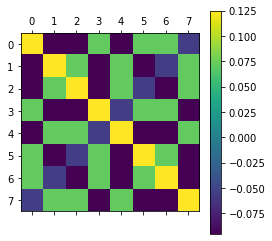

Expectation Value: -2.2847824678672937
Entropy: 1.096001565261623
Final Cost: -3.3807840331289167


In [73]:
# Initializes values

beta = 1 #Note that B = 1/T
qubit = 3

# Creates the target density matrix

def create_target(qubit, beta):

    h = create_hamiltonian_matrix(qubit)
    y = -1*float(beta)*h
    new_matrix = scipy.linalg.expm(np.array(y))
    norm = np.trace(new_matrix)
    final_target = (1/norm)*new_matrix

    # Calculates the entropy, the expectation value, and the final cost

    entropy = -1*np.trace(np.matmul(final_target, scipy.linalg.logm(final_target)))
    ev = np.trace(np.matmul(final_target, h))
    real_cost = beta*np.trace(np.matmul(final_target, h)) - entropy

    # Plots the final density matrix

    create_density_plot(final_target.real)

    # Prints the calculated values

    print("Expectation Value: "+str(ev))
    print("Entropy: "+str(entropy))
    print("Final Cost: "+str(real_cost))

create_target(qubit, beta)

So now that have an idea of what our colorful density matrix should look like at the end of our simulation, we can start implementing the VQT!

First things first, we have to take a short but crucial detour...

**A Small Tangent: Constructing the RYY Gate**

In order to implement the state-preparation ansatz circuit outlined in the original paper, one of the necessary gates that must be applied to our qubit register is the exponential $Y \ \otimes \ Y$ coupling gate. Qiskit only supports the $RZZ$ and the $RXX$ gates, so it is necessary to decompose our $RYY$ gate into a product of these gates. This is fairly simple. We define the exponential $YY$ gate as:

$$RYY(\theta) \ = \ \exp \Big( -i\theta (Y \ \otimes \ Y) \Big)$$

We assert that: $RYY(\theta) \ = \ (S \ \otimes \ S) \ RXX(\theta) \ (S^{\dagger} \ \otimes S^{\dagger})$, where $S$ is the phase gate. This is easy to prove:

$$(S \ \otimes \ S) \ RXX(\theta) \ (S^{\dagger} \ \otimes S^{\dagger}) \ = \ (S \ \otimes S) \ \exp \Big( -i\theta (X \ \otimes \ X) \Big) \ (S^{\dagger} \ \otimes S^{\dagger}) \ = \ \exp \Big( -i\theta (S X S^{\dagger} \ \otimes \ S X S^{\dagger}) \Big)$$
<br>
$$\Rightarrow \ \exp \Big( -i\theta (S X S^{\dagger} \ \otimes \ S X S^{\dagger}) \Big) \ = \ \exp \Big( -i\theta (Y \ \otimes \ Y) \Big) \ = \ RYY(\theta)$$

We are allowed to bring our $S$ and $S^\dagger$ operations into the exponential due to unitary exponentiation:

$$U \exp (A) U^{\dagger} \ = \ U \Big( \displaystyle\sum_{n \ = \ 0}^{\infty} \frac{(A \ \mathbb{I})^n}{n!} \Big) U^{\dagger} \ = \ \Big( \displaystyle\sum_{n \ = \ 0}^{\infty} \frac{U (A \ U^\dagger U)^n U^\dagger}{n!} \Big) \ = \ \Big( \displaystyle\sum_{n \ = \ 0}^{\infty} \frac{(UAU^\dagger)^n}{n!} \Big) \ = \ \exp (U A U^\dagger)$$

We can code this up in Qiskit with relative ease!

In [74]:
#Creates the RYY gate using the RXX gate and single-qubit rotations

def ryy_gate(circ, qubit1, qubit2, theta):

    circ.s(qubit1)
    circ.s(qubit2)
    circ.rxx(theta, qubit1, qubit2)
    circ.sdg(qubit1)
    circ.sdg(qubit2)

Ok, so now that the $RYY$ gate is ready to be used, we can begin by constructing our ansatz unitary, which serves the purpose of coupling together and "mixing around" our parametrized subpsaces, in the $VQE$-like fashion. Since the Hamiltonian we have defined has no coupling, we won't need any coupling terms in our ansatz. Thus, keeping our ansatz general, we choose:

$$U(\phi) \ = \ Ry(\phi_1) \ Rx (\phi_2) \ Rz(\phi_3)$$

applied to each of the qubits. We can code this up fairly easily:

In [75]:
# Creates the single rotational ansatz

def single_rotation(circ, phi_params, qubit):

    circ.rz(phi_params[0], qubit)
    circ.ry(phi_params[1], qubit)
    circ.rx(phi_params[2], qubit)

We then write a function for applying the unitary gate onto the circuit:

In [76]:
# Sets the depth of our unitary circuit

depth = 1

# Creates the U gate unitary to apply to the initial qubit state

def add_u_gate(circ, single_phi, qubit):
    for j in range(0, depth):
        for i in range(0, qubit):
            single_rotation(circ, single_phi[j][i], i)

Now, let's turn our attention to creating the initial probability distribution and initializing the state corresponding to the value sampled from the probability distribution. We can pretty easily create a function that initializes a probability distribution for each parameter $\theta_j$:

In [77]:
# Creates the probability distribution according to the theta parameters

def create_dist(theta_param):

    prob = []
    for i in range(0, len(theta_param)):
        prob.append([math.exp(-1*theta_param[i]), 1-math.exp(-1*theta_param[i])])

    return prob

As you can see, we create a list with elements $e^{-\theta_j}$ and $1 \ - \ e^{-\theta_j}$. We can also very easily create our $V$ gate that initializes a basis state corresponding to an inputted list of $0$s and $1$s:

In [78]:
#Creates the initialization unitary for each of the computational basis states

def create_v_gate(circ, prep_state):

    for i in range(0, len(prep_state)):
        if (prep_state[i] == 1):
            circ.x(i)

Great, so now we have most of the building blocks we need in order to create our VQT circuit! We can now create our cost function, which essentially simulates our circuit for certain variational parameters, then **numerically** calculates the cost function corresponding to the preparred state. We can then optimize this cost function to find the thermal state corresponding to our Hamiltonian/temperature.

In [97]:
#Numerical cost function

counting_num = 0

def cost_function(param):
    
    global counting_num
    
    # Prepares the Hamiltonian
    ham_matrix = create_hamiltonian_matrix(qubit)

    # Splits the inputted list of parameters into our lists phi and theta
    single_phi = [[param[0:3], param[3:6], param[6:9]]]
    theta = param[9:12]
    
    # Prepares the probability distribution
    opt_prob_dist = create_dist(theta)
    
    # Calculates the probability of (This is NUMERICAL, not how the algorithm would function in reality)
    p = []
    for i in range(0, 2):
        for j in range(0, 2):
            for v in range(0, 2):
                p.append(opt_prob_dist[0][i]*opt_prob_dist[1][j]*opt_prob_dist[2][v])

    # Creates and empty matrix initializing our density matrix
    state = np.zeros((2**qubit, 2**qubit))

    for l in range(0, 2**qubit):
        
        # Creates the circuit
        circ = QuantumCircuit(qubit)
        create_v_gate(circ, [int(i) for i in list(bin(l)[2:].zfill(qubit))])
        add_u_gate(circ, single_phi, qubit)

        # Simulates the circuit
        backend = Aer.get_backend('statevector_simulator')
        job = execute(circ, backend)
        result = job.result()
        outputstate = result.get_statevector(circ)

        # Adds a term to our "density matrix sum"
        state = np.add(state, p[l]*np.outer(outputstate, np.conj(outputstate)))

    # Calculates the entropy of our state
    entropy = -1*np.trace(np.matmul(state, scipy.linalg.logm(state)))

    #Calculates our final cost function
    cost = beta*np.trace(np.matmul(ham_matrix, state)) - entropy
    
    if (counting_num%20 == 0):
        print("Cost at Step "+str(counting_num)+": "+str(cost.real))
    counting_num += 1
    return cost.real

We can now finally go about optimizing our cost function in order to find the correct state, finding the optimal $\phi$ and $\theta$ parameters, then feeding these optimal parameters back into our circuit to find the optimal mixed state (which should correspond to the thermal state)!

Cost at Step 0: -1.88321130679823
Cost at Step 20: -2.421040917200288
Cost at Step 40: -3.0466642186783304
Cost at Step 60: -3.3407497656733067
Cost at Step 80: -3.376408386191768
Cost at Step 100: -3.3804220358754673
Cost at Step 120: -3.3807175121891224
Cost at Step 140: -3.3807746326316708
Cost at Step 160: -3.3807818028832886
Cost at Step 180: -3.380783121312982
     fun: -3.380783880762759
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 200
  status: 2
 success: False
       x: array([ 0.20472473,  1.57128921,  3.36788328,  0.38620968,  1.57103638,
       -1.50780847,  1.68217648,  1.57065217, -0.49372566,  2.12685663,
        2.1275784 ,  2.12705208])


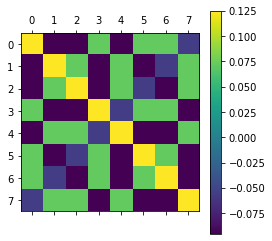

Final Entropy: 1.0958339683236558
Final Expectation Value: -2.284949912439103
Final Cost: -3.380783880762759


In [98]:
#Creates lists of random numbers as the initial parameters fed into the circuit

init1 = [random.randint(100, 200)/100 for i in range(0, qubit)]
init2 = [random.randint(-100, 100)/50 for i in range(0, 3*qubit)]
init = init2+init1

#Creates the optimization process

out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':200})
g = out['x']
print(out)

param = g

# Prepares the learned state

single_phi = [[param[0:3], param[3:6], param[6:9]]]
theta = param[9:12]

opt_prob_dist = create_dist(theta)

p = []
for i in range(0, 2):
    for j in range(0, 2):
        for v in range(0, 2):
            p.append(opt_prob_dist[0][i]*opt_prob_dist[1][j]*opt_prob_dist[2][v])

state = np.zeros((2**qubit, 2**qubit))

for l in range(0, 2**qubit):

    circ = QuantumCircuit(qubit, qubit)
    create_v_gate(circ, [int(i) for i in list(bin(l)[2:].zfill(qubit))])
    add_u_gate(circ, single_phi, qubit)

    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    outputstate = result.get_statevector(circ)

    state = np.add(state, p[l]*np.outer(outputstate, np.conj(outputstate)))

ham_matrix = create_hamiltonian_matrix(qubit)
entropy = -1*np.trace(np.matmul(state, scipy.linalg.logm(state)))
ev = np.trace(np.matmul(ham_matrix, state))

create_density_plot(state.real)

print("Final Entropy: "+str(entropy.real))
print("Final Expectation Value: "+str(ev.real))
print("Final Cost: "+str(beta*ev.real - entropy.real))

So it looks like our simulation did quite well!

#### **Another Sanity Check: Numerical Simulations of the VQT For Coupled Hamiltonians**

Ok, so we've shown that the VQAT works when faced with an incredibly basic Hamiltonian. However, in my opinion, the example that we just did was pretty boring. We want to show that our factorized latent space works even in the fact of coupling between the different subsystems, instead of keeping each of the subsystems independent of one another. For that reason, we're going to do one more numerical simulation, this time of a more complex Hamiltonian: the one-dimension Heisenberg model.

The Hamiltonian for the Heisenberg model looks something like this:

$$\hat{H} \ = \ \displaystyle\sum \ \textbf{S}_i \ \cdot \ \textbf{S}_{i+1} \ + \ \displaystyle\sum \ X_i \ = \ \displaystyle\sum \ X_i X_{i+1} \ + \ Y_i Y_{i+1} \ + \ Z_i Z_{i+1} \ + \ \displaystyle\sum \ X_i$$

Let's first take a look at what the density matrix/cost is **supposed to be** for this Hamiltonian. We'll start by making a minor modification to our previous "matrix construction" function to create the Heisenberg Hamiltonian:

In [99]:
def create_hamiltonian_matrix(n):

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, -1j], [1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])

    matrix = np.zeros((2**n, 2**n))

    for i in range(0, n-1):
        m = 1
        for j in range(0, n):
            if (j == i or j == i+1):
                m = np.kron(m, pauli_x)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)

    for i in range(0, n-1):
        m = 1
        for j in range(0, n):
            if (j == i or j == i+1):
                m = np.kron(m, pauli_y)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)

    for i in range(0, n-1):
        m = 1
        for j in range(0, n):
            if (j == i or j == i+1):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)

    for i in range(0, n):
        m = 1
        for j in range(0, n):
            if (j == i):
                m = np.kron(m, pauli_x)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)


    return matrix

print(create_hamiltonian_matrix(3))

[[ 2.+0.j  1.+0.j  1.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j  0.+0.j  2.+0.j  1.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j  2.+0.j -2.+0.j  1.+0.j  2.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  1.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  1.+0.j]
 [ 1.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  1.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  2.+0.j  1.+0.j -2.+0.j  2.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  1.+0.j  2.+0.j  0.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  1.+0.j  1.+0.j  2.+0.j]]


And now we can use the same function as before to create our target density matrix, with $3$ qubits and $\beta\ = \ 1$:

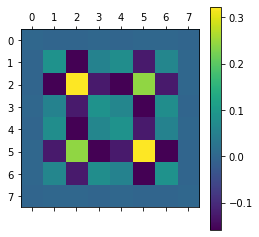

Expectation Value: (-4.617704476259032+0j)
Entropy: (0.5455233906195588-8.078345085123659e-18j)
Final Cost: (-5.163227866878591+8.078345085123659e-18j)


In [100]:
qubit = 3
beta = 1
create_target(qubit, beta)

Now, we can begin modifying the code that we used for the first Hamiltonian to simulate the Heisenberg model! We will start with redefining our ansatz unitary. This time, we will be utilizing a staggered layer of double qubit and single qubit interactions. We will have:

$$\hat{U}(\phi)_{\text{Double}} \ = \ [RZZ(\phi_1) \ RXX(\phi_2) \ RYY(\phi_3)]_{i, \ i+1}$$
<br>
$$\hat{U}(\phi)_{\text{Single}} \ = \ [RZ(\phi_1) \ RY(\phi_2) \ RX(\phi_3)]_{i} \ \otimes \ [RZ(\phi_4) \ RY(\phi_5) \ RX(\phi_6)]_{i+1}$$

With our overall unitary for two qubits.

$$\hat{U}(\phi) \ = \ \hat{U}(\phi_a)_{\text{Double}} \hat{U}(\phi_b)_{\text{Single}} \hat{U}(\phi_a)_{\text{Double}}$$

We then apply this unitary to all neighbouring pairs of qubits. In our case (3 qubits), we will apply it to qubits 1 and 2, then qubits 2 and 3. It isn't necessary to "interact" qubit 1 and qubit 3 directly, as they are not subject to any interaction terms in the Hamiltonian itself. In order to construct our unitary, we will construct a "double rotation" method:

In [101]:
#Creates the double rotational unitary

def double_rotation(circ, phi_params, qubit1, qubit2):

    circ.rzz(phi_params[0], qubit1, qubit2)
    circ.rxx(phi_params[1], qubit1, qubit2)
    ryy_gate(circ, qubit1, qubit2, phi_params[2])

While we're at it, we can also re-define our ansatz unitary:

In [102]:
double_pair = [[[0, 1], [1, 2]]]

#Creates the ansatz unitary

def add_u_gate(circ, double_phi, single_phi, qubit):
    for j in range(0, depth):

        for i in range(0, qubit-1):
            double_rotation(circ, double_phi[j][i], double_pair[j][i][0], double_pair[j][i][1])

        for i in range(0, qubit):
            single_rotation(circ, single_phi[j][i], i)

        for i in range(0, qubit-1):
            double_rotation(circ, double_phi[j][i], double_pair[j][i][0], double_pair[j][i][1])

Notice how I've specified where I want to double rotation gates applied in a list, just in case we want to change it later.

We then have to update our cost function and our output. Literally, the only changes we have to make are changing the parameter lists, and adding the `double_phi` variable to our ansatz function calls:

Cost at Step 0: -1.6546704718717633
Cost at Step 50: -3.5138843647456897
Cost at Step 100: -4.481541089498662
Cost at Step 150: -4.769712265199862
Cost at Step 200: -4.832128643160377
Cost at Step 250: -4.878083652608903
Cost at Step 300: -4.903950178149941
Cost at Step 350: -4.922529185866541
Cost at Step 400: -4.937353948380316
Cost at Step 450: -4.9501125955452245
     fun: -4.958525694198875
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 500
  status: 2
 success: False
       x: array([ 1.18745412e+00, -1.93532388e+00, -3.62236383e-01,  1.03521885e-02,
       -7.79770898e-01,  2.42784797e-03,  9.03940068e-03,  2.35957793e-01,
       -3.21288790e-01,  1.56008019e+00,  3.38015364e+00, -1.25486542e+00,
       -4.86757526e-01,  1.56913003e+00,  9.79681016e-01,  3.70028190e+00,
        3.30643044e+00,  3.65937468e+00])


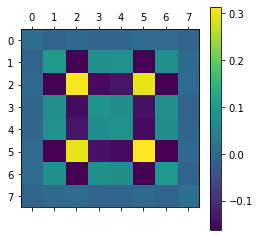

Final Entropy: 0.3926416700388085
Final Expectation Value: -4.5658840241600664
Final Cost: -4.958525694198875


In [103]:
counting_num = 0

def cost_function(param):
    
    global counting_num

    ham_matrix = create_hamiltonian_matrix(qubit)

    double_phi = [[param[0:3], param[3:6]]]
    single_phi = [[param[6:9], param[9:12], param[12:15]]]
    theta = param[15:18]

    opt_prob_dist = create_dist(theta)

    p = []
    for i in range(0, 2):
        for j in range(0, 2):
            for v in range(0, 2):
                p.append(opt_prob_dist[0][i]*opt_prob_dist[1][j]*opt_prob_dist[2][v])

    state = np.zeros((2**qubit, 2**qubit))

    for l in range(0, 2**qubit):

        circ = QuantumCircuit(qubit)

        create_v_gate(circ, [int(i) for i in list(bin(l)[2:].zfill(qubit))])
        add_u_gate(circ, double_phi, single_phi, qubit)

        backend = Aer.get_backend('statevector_simulator')
        job = execute(circ, backend)
        result = job.result()
        outputstate = result.get_statevector(circ)

        state = np.add(state, p[l]*np.outer(outputstate, np.conj(outputstate)))

    entropy = -1*np.trace(np.matmul(state, scipy.linalg.logm(state)))

    cost = beta*np.trace(np.matmul(ham_matrix, state)) - entropy
    if (counting_num%50 == 0):
        print("Cost at Step "+str(counting_num)+": "+str(cost.real))
    counting_num += 1
    return cost.real

#Creates lits of random numbers as the initial parameters fed into the circuit

init1 = [random.randint(100, 200)/100 for i in range(0, qubit)]
init2 = [random.randint(-100, 100)/50 for i in range(0, 5*qubit)]
init = init2+init1

#Creates the optimization process

out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':500})
g = out['x']
print(out)

param = g

# Prepares the learned state

double_phi = [[param[0:3], param[3:6]]]
single_phi = [[param[6:9], param[9:12], param[12:15]]]
theta = param[15:18]

opt_prob_dist = create_dist(theta)

p = []
for i in range(0, 2):
    for j in range(0, 2):
        for v in range(0, 2):
            p.append(opt_prob_dist[0][i]*opt_prob_dist[1][j]*opt_prob_dist[2][v])

state = np.zeros((2**qubit, 2**qubit))

for l in range(0, 2**qubit):

    circ = QuantumCircuit(qubit, qubit)
    create_v_gate(circ, [int(i) for i in list(bin(l)[2:].zfill(qubit))])
    add_u_gate(circ, double_phi, single_phi, qubit)

    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    outputstate = result.get_statevector(circ)

    state = np.add(state, p[l]*np.outer(outputstate, np.conj(outputstate)))

ham_matrix = create_hamiltonian_matrix(qubit)
entropy = -1*np.trace(np.matmul(state, scipy.linalg.logm(state)))
ev = np.trace(np.matmul(ham_matrix, state))

create_density_plot(state.real)

print("Final Entropy: "+str(entropy.real))
print("Final Expectation Value: "+str(ev.real))
print("Final Cost: "+str(beta*ev.real - entropy.real))

So the algorithm did pretty well (it would do even better with more optimization steps, but I decided to stop it at 500 so the list of numbers above wasn't too long)!

#### **Sampling Simulation of the VQT**

Alright, so now that we have completed our numerical simulations (our sanity checks), we can now create our sampling-based simulation. This is only going to take some minor modification to our cost function. For this simulation, we'll use the same Hamiltonian, but let's change the value of $\beta$:

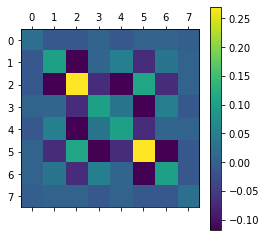

Expectation Value: (-3.508493781083069+0j)
Entropy: (1.3128708190626326-0j)
Final Cost: (-3.067117709604167+0j)


In [54]:
beta = 0.5
create_target(qubit, beta)

In [65]:
def run_circuit(qubit, theta, double_phi, single_phi):
    
    circ = QuantumCircuit(qubit, qubit)

    prob = create_dist(theta)

    # Sample values for each of the qubits
    samples = []
    for dist in prob:
        sample = list(np.random.choice(2, 1, p=[dist[0], dist[1]]))[0]
        samples.append(sample)

    #Prepares the initial state corresponding to the sampled values
    create_v_gate(circ, samples)

    #Apply the unitary to this combination of basis states
    add_u_gate(circ, double_phi, single_phi, qubit)

    
    #Compute the expectation value of the Hamiltonian
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    outputstate = result.get_statevector(circ)
    
    ham_matrix = create_hamiltonian_matrix(qubit)
    
    e_val = np.inner(np.conj(outputstate), np.matmul(ham_matrix, outputstate)).real

    return [e_val, samples]

In [68]:
# NUMERICAL COST FUNCTION

runs = 40

def cost_function(param):

    # Creates different phi and theta param lists

    double_phi = [[param[0:3], param[3:6]]]
    single_phi = [[param[6:9], param[9:12], param[12:15]]]
    theta = param[15:18]

    # Repeatedly calculate the expectation value of our Hamiltonian for different sampled |x>

    ev = 0
    entropy = [[0 for j in range(0, 2)] for i in range(0, qubit)]

    for i in range(0, runs):
        res = run_circuit(qubit, theta, double_phi, single_phi)
        ev += res[0]
        for k in range(0, len(res[1])):

            # Tracks the number of samples corresponding to the different basis states

            if (res[1][k] == 0):
                entropy[k][0] += 1
            if (res[1][k] == 1):
                entropy[k][1] += 1

    final_entropy = 0
    for i in range(0, len(entropy)):
        if (entropy[i][0] != 0):
            final_entropy -= (entropy[i][0]/runs) * np.log(entropy[i][0]/runs)
        if (entropy[i][1] != 0):
            final_entropy -= (entropy[i][1]/runs) * np.log(entropy[i][1]/runs)
    
    cost = beta*float(ev/runs) - final_entropy
    print("Cost Function: "+str(cost))
    return cost

Cost Function: -1.7468352682180865
Cost Function: -1.8954879909393958
Cost Function: -2.0373504479117064
Cost Function: -1.7895769572933682
Cost Function: -1.848170824429419
Cost Function: -1.392958146261632
Cost Function: -1.9413308896723351
Cost Function: -1.6107500233294527
Cost Function: -1.994633384805878
Cost Function: -1.5859197612501648
Cost Function: -1.6637770495830204
Cost Function: -1.559551391880564
Cost Function: -1.5793019839589253
Cost Function: -1.6726471363759974
Cost Function: -1.8787023648546812
Cost Function: -2.041438896016107
Cost Function: -1.4745714103207903
Cost Function: -1.7907017728677443
Cost Function: -1.5278716830276866
Cost Function: -1.859214557457854
Cost Function: -1.5366046277315613
Cost Function: -1.9120805653526258
Cost Function: -1.6163766963866033
Cost Function: -1.8383732413512677
Cost Function: -1.5455882731807364
Cost Function: -1.7725352270538397
Cost Function: -1.9644950737220785
Cost Function: -1.8288832412417104
Cost Function: -1.89986845

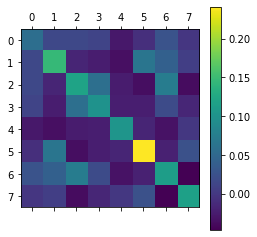

Final Entropy: 1.5562136326637188
Final Expectation Value: -0.532850531190646
Final Cost: -1.8226388982590418


In [69]:
#Creates lits of random numbers as the initial parameters fed into the circuit

init1 = [random.randint(100, 200)/100 for i in range(0, qubit)]
init2 = [random.randint(-100, 100)/50 for i in range(0, 5*qubit)]
init = init2+init1

#Creates the optimization process

out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':500})
g = out['x']
print(out)

param = g

# Prepares the learned state

double_phi = [[param[0:3], param[3:6]]]
single_phi = [[param[6:9], param[9:12], param[12:15]]]
theta = param[15:18]

opt_prob_dist = create_dist(theta)

p = []
for i in range(0, 2):
    for j in range(0, 2):
        for v in range(0, 2):
            p.append(opt_prob_dist[0][i]*opt_prob_dist[1][j]*opt_prob_dist[2][v])

state = np.zeros((2**qubit, 2**qubit))

for l in range(0, 2**qubit):

    circ = QuantumCircuit(qubit, qubit)
    create_v_gate(circ, [int(i) for i in list(bin(l)[2:].zfill(qubit))])
    add_u_gate(circ, double_phi, single_phi, qubit)

    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    outputstate = result.get_statevector(circ)

    state = np.add(state, p[l]*np.outer(outputstate, np.conj(outputstate)))

ham_matrix = create_hamiltonian_matrix(qubit)
entropy = -1*np.trace(np.matmul(state, scipy.linalg.logm(state)))
ev = np.trace(np.matmul(ham_matrix, state))

create_density_plot(state.real)

print("Final Entropy: "+str(entropy.real))
print("Final Expectation Value: "+str(ev.real))
print("Final Cost: "+str(beta*ev.real - entropy.real))

#### **Conclusion**

To wrap up this Notebook, I thought it would be interesting to create some nice animations of the VQT in action!

For the sake of further visualization of what is actually going on under the hood of this algorithm, we can actually save images of the density matrix at each optimization step of the simulation. I was able to create a couple videos, the first of which shows the process of learning the density matrix of a specific thermal state of the Heisenberg Hamiltonian, and the second showing how the density matrix changes as temperature is increased:

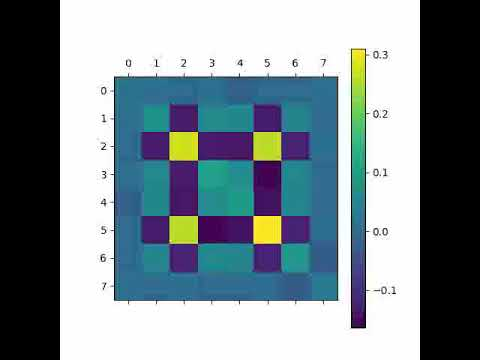

In [46]:
YouTubeVideo('zKkGg8pvZ9g')

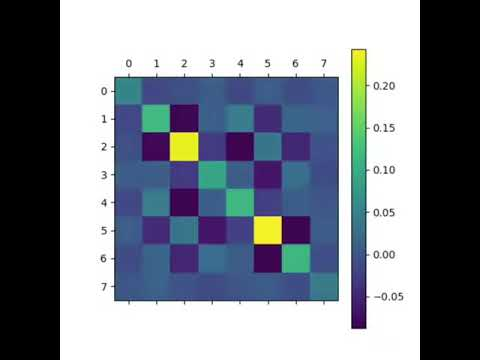

In [47]:
YouTubeVideo('wK-M-h7y_a8')

This algorithm has some very interesting applications. Preparation of thermal states using a quantum computer has very interesting applications in the field of computational quantum statistical mechanics, and computational moedlling of materials (the original VQT paper talks about a use case of calculating the thermal states of the $d$-wave superconductor). In addition to this, a lot of the underlying ideas in this algorithm can be used for an interesting process in generative quantum mechanics learning, where the algorithm is given many copies of a thermal state

#### **References**

